# 高光谱图像处理

##  构建数据集

**同时遍历总矩阵以及标签矩阵，两个矩阵二维平面对应，通过label矩阵判断，如果为0就略掉，说明是黑点，如果不是零，就取一部分，构建一个新的.mat文件，将这些文件填入到一个总的文件夹中，作为总的数据集。**


In [17]:
'''
导入os库删除path目录下的所有文件，用于清除文件夹。这里用于清除先前存储的.mat文件，重构数据集。
'''
import os
def del_files(path):
    for root, dirs, files in os.walk(path):
        for name in files:
            os.remove(os.path.join(root, name))
    print('Deleting completed!')
# test
if __name__ == "__main__":
    path_1='all_data\\'
    path_2='all_test_data\\'
    del_files(path_1)
    del_files(path_2)

Deleting completed!
Deleting completed!


## 文件路径等信息

In [124]:
import scipy.io as scio
import numpy as np
import csv
import os
import torch
import torch.nn.functional as F

from torch.autograd import Variable



data_total_path="all_data//"
data_train_path="all_train_data//"
data_test_path="all_test_data//"
data_test_new_path="all_test_new_data//"
cluster_message_path="cluster//"


each_other_dist_file="each_other_dist.csv"

label_file_name="Indian_pines_gt.mat"
data_file_name="Indian_pines.mat"

## 完成数据集的构建

* 求得总数据集
* 更新三个空文件夹
* 以某种算法分配测试集和训练集


In [19]:
label_file=scio.loadmat(label_file_name)
data_file=scio.loadmat(data_file_name)


label_array=label_file['indian_pines_gt']
data_array=data_file['indian_pines']


#矩阵类型为numpy.array，shape为145*145*220。
#处理矩阵外围数据

data_fin_array=np.zeros([149,149,220],np.uint8)
data_fin_array[2:147,2:147,:]=data_array

index=0

#构建总数据集
#构建训练集
#构建测试集
for i in range(2,147):
    for j in range(2,147):
        index+=1
        #不为0符合添加条件
        if label_array[i-2][j-2]!=0 :
            data_now=data_fin_array[i-2:i+3,j-2:j+3,:]
            scio.savemat(data_total_path+str(i)+str(j)+".mat",{"label":label_array[i-2][j-2],"data":data_now})
            if index%30==0:
                scio.savemat(data_test_path+str(i)+str(j)+".mat",{"label":label_array[i-2][j-2],"data":data_now})
            if i==2 or j==2 or i==146 or j==146 :
                scio.savemat(data_train_path+str(i)+str(j)+".mat",{"label":label_array[i-2][j-2],"data":data_now})
                continue
            if index%10==0 :
                scio.savemat(data_train_path+str(i)+str(j)+".mat",{"label":label_array[i-2][j-2],"data":data_now})
        else:
            continue


# 基于快速搜索和局部密度峰值的聚类

## 目标：用所有数据点做聚类


* 处理数据
* 为数据打点
* 计算欧氏距离
* 将数据写入csv文件。

In [20]:
'''
dist:calculate the Euclidean distance between vectors
dist函数：计算向量间的欧氏距离
'''
def dist(vec_a,vec_b):
    return np.sqrt(np.sum(np.square(vec_a-vec_b)))

In [5]:
'''
这里写入csv文件，由于文件数量过大，以及欧氏距离的复杂计算，本设备不支持计算过大的数据，选取其中一部分数据进行测试。
'''
for root, dirs, files in os.walk(data_total_path):
    file_len=len(files)
    print(file_len)
    with open(each_other_dist_file,"w",newline="") as file_write:
        #创建写入对象
        file_writer=csv.writer(file_write)
        for i in range(int(file_len*0.05)-1):
            for j in range(i+1,int(file_len*0.05)):
                #这里注意更新列表，否则每一次添加列表会导致文件巨大。。。。
                write_to_list=[]
                vec_a=scio.loadmat(root+files[i])["data"]
                vec_b=scio.loadmat(root+files[j])["data"]
                dist_now=dist(vec_a,vec_b)
                write_to_list.append(i)
                write_to_list.append(j)
                write_to_list.append(dist_now)
                file_writer.writerow(write_to_list)
                
            

10044


# 对部分数据，做聚类任务，基于快速搜索和局部密度峰值的聚类

加载文件
198
199
199
average percentage of neighbours: 2.0
截断距离是: 685.7317259686911
767.6405408783462
Generated file:DECISION GRAPH
column 1:Density
column 2:Delta


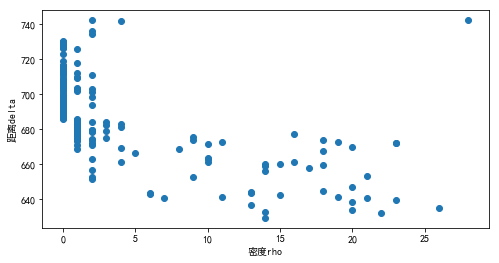

please input rho密度最小值22
please input delta距离最小值660
NUMBER OF CLUSTERS: 3 

Performing assignation


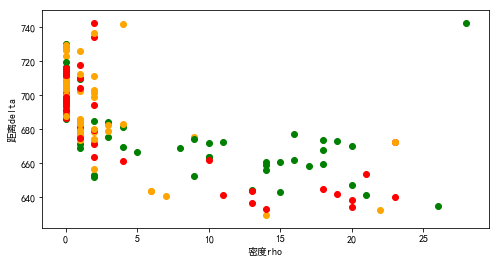

打点结束


In [26]:
'''
完成聚类任务。
'''


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


plt.rcParams['figure.figsize'] =(8.0,4.0) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style

#防止绘图出现乱码的问题
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

#加载文件
print("加载文件")
xx=pd.read_csv('each_other_dist.csv',sep=",",header=None)

NL=max(xx[0])
ND=max(xx[1])
print(NL)
if NL>ND:
    ND=NL #确保 ND 取为第一二列最大值中的较大者，并将其作为数据点总数
N = len(xx)#距离个数  xx 第一个维度的长度，相当于文件的行数（即距离的总个数）

#初始化为dist数组为0
print(ND)
dist=np.zeros([ND,ND])
print(dist.shape[0])
#print(xx[2][2000])

#为dist数组赋值
for i in range(N):
    ii = xx[0][i]-1
    jj = xx[1][i]-1
    #将距离赋予矩阵
    dist[ii][jj]=xx[2][i]
    dist[jj][ii]=xx[2][i]
# 测试赋值所需时间

#取截断距离
percent=2.0
print("average percentage of neighbours:",percent)

position=round(N*percent/100); #round 是一个四舍五入函数
sda=xx[2].sort_values().tolist()
dc=sda[position]
#输出截断距离
print("截断距离是:",dc)

#计算局部密度 rho(用Gaussian高斯核）
from math import exp

#1.将每个数据点的rho值初始化为0
rho=np.zeros(ND)

 #"Cut off" kernel

for i in range(1,ND-1):
    for j in range(i+1,ND):
        if dist[i,j]<dc:
            rho[i]=rho[i]+1.;
            rho[j]=rho[j]+1.;

# 先求矩阵列最大值，再求最大值，最后得到所有距离值中的最大值
maxd=dist.max()
print(maxd)

#将密度rho降序排列，ordho保持序
ordrho = np.argsort(-1*rho)
rho_sorted =rho[ordrho]

#初始化delta数组和nneigh数组
delta=[maxd]*ND
nneigh=[0]*ND
 #处理 rho 值最大的数据点
delta[ordrho[0]] = -1
nneigh[ordrho[0]] = 0

#delta 和 nneigh 数组赋值
for ii in range(1,ND):
    for jj in range(0,ii):
        if dist[ordrho[ii],ordrho[jj]]<delta[ordrho[ii]]:
            delta[ordrho[ii]]=dist[ordrho[ii],ordrho[jj]]
            nneigh[ordrho[ii]]=ordrho[jj]
# 记录 rho 值更大的数据点中与 ordrho(ii) 距离最近的点的编号 ordrho(jj)

# 生成 rho 值最大数据点的 delta 值
delta[ordrho[0]]=max(delta)

# 决策图
print('Generated file:DECISION GRAPH')
print('column 1:Density')
print('column 2:Delta')
#开画图文件写画图文件
with open(cluster_message_path+'DECISION_GRAPH','w') as fid:
    for i in range(ND):
        fid.write('%6.2f %6.2f\n'%(rho[i],delta[i]))
#选择一个围住类中心的矩形
#print('Select a rectangle enclosing cluster centers')
#scrsz = get(0,'ScreenSize');
#figure('Position',[6 72 scrsz(3)/4. scrsz(4)/1.3]);
plt.xlabel('密度rho')
plt.ylabel('距离delta')
plt.scatter(rho,delta)
plt.show()


#输入选取聚类中心的范围（最小值）
rhomin=int(input("please input rho密度最小值"))
deltamin=float(input("please input delta距离最小值"))

#初始化 cluster 个数
NCLUST=0;

# cl 为归属标志数组，cl[i]=j 表示第 i 号数据点归属于第 j 个 cluster
#先统一将 cl 初始化为 -1
cl=[-1]*ND
#初始化 点映射到类别列表
icl=[-1]*10

#在矩形区域内统计数据点（即聚类中心）的个数
for i in range(ND):
    if  (rho[i]>rhomin) and (delta[i]>deltamin):
        NCLUST=NCLUST+1;
        cl[i]=NCLUST # 第 i 号数据点属于第 NCLUST 个 cluster
        #icl[NCLUST]=i # 逆映射,第 NCLUST 个 cluster 的中心为第 i 号数据点

print('NUMBER OF CLUSTERS: %i \n'%NCLUST)
print('Performing assignation')

#将其他数据点归类 (assignation)
for i in range(ND):
    if (cl[ordrho[i]]==-1):
        cl[ordrho[i]]=cl[nneigh[ordrho[i]]]

#由于是按照 rho 值从大到小的顺序遍历,循环结束后, cl 应该都变成正的值了

halo=[-1]*ND
rho_aver=0
#处理光晕点：
if (NCLUST>1):
    for i in range(ND):
        halo[i]=cl[i]
    bord_rho=np.zeros(NCLUST+1)
#初始化数组 bord_rho 为 0,每个 cluster 定义一个 bord_rho 值
#获取每一个 cluster 中平均密度的一个界 bord_rho
    for i in range(ND - 1):
        for j in range(i+1,ND):
# 距离足够小但不属于同一个cluster的i和j
            if (cl[i]!=cl[j]) and (dist[i,j]<= dc):
                rho_aver = (rho[i] + rho[j]) / 2
# 取i, j两点的平均局部密度
                if rho_aver > bord_rho[cl[i]]:
                    bord_rho[cl[i]] = rho_aver

                if rho_aver > bord_rho[cl[j]]:
                    bord_rho[cl[j]] = rho_aver



#halo 值为 0 表示为 outlier
for i in range(ND):
    if rho[i]<bord_rho[cl[i]]:
        halo[i]=0

#逐一处理每个 cluster
for i in range(NCLUST):
    nc=0; #用于累计当前 cluster 中数据点的个数
    nh=0; # 用于累计当前 cluster 中核心数据点的个数
    for j in range(ND):
        if cl[j]==i:
            nc=nc+1

        if halo[j]==i:
            nh=nh+1

#写聚类后的打标文件
with open(cluster_message_path+'clustered_data.txt','w') as fp:
    for i in range(ND):
        fp.write('%d,%6.2f,%6.2f,%d\n'%(i,rho[i],delta[i],cl[i]))


colors = ['b','g','r','orange','c','m','y','k','w','p','gray','darkred','peru','sandybrown','pink','cyan']
plt.xlabel('密度rho')
plt.ylabel('距离delta')
for i in range(ND):
    for j in range(len(colors)):
        if int(cl[i]) == j:
            plt.scatter(rho[i], delta[i],c=colors[j])
            continue
plt.show()
print("打点结束")

# 构建BP网络，部分训练集

* 多分类网络，经过统计数据分为16类。
* 利用文件的data和label构建数据集，先用测试集训练网络。
* 构建var数据集，pytorch神经元接受var输入。
* 利用pytorch搭建多分类网络（网络分为回归和分类）。

In [21]:
def print_files(path):
    for root, dirs, files in os.walk(path):
        for name in files:
            scio.loadmat(os.path.join(root, name))
        print("finished")
        
        

In [105]:
#训练集和测试集的列表，这里用列表存储np.array
train_x,train_y=[],[]

for root, dirs, files in os.walk(data_train_path):
    for name in files:
        src=scio.loadmat(os.path.join(root, name))
        src_data=src["data"].reshape(5500)
        train_x.append(src_data)
        train_y_now=src["label"]-1
        train_y.append(train_y_now[0])
    print("load data finished!")



load data finished!


In [106]:
x=Variable(torch.FloatTensor(train_x))
y=Variable(torch.FloatTensor(train_y)).reshape(1073,).type(torch.LongTensor)

In [107]:
print(x.shape)
print(y.shape)

torch.Size([1073, 5500])
torch.Size([1073])


## 网络结构

* 5500->200->16

In [113]:




class Net(torch.nn.Module):
    def __init__(self,n_feature,n_hidden_1,n_hidden_2,n_hidden_3,n_output):
        super(Net,self).__init__()
        self.hidden_1=torch.nn.Linear(n_feature,n_hidden_1)
        self.hidden_2=torch.nn.Linear(n_hidden_1,n_hidden_2)
        self.hidden_3=torch.nn.Linear(n_hidden_2,n_hidden_3)
        self.predict=torch.nn.Linear(n_hidden_3,n_output)
        
    def forward(self,x):
        x=F.relu(self.hidden_1(x))
        x=F.relu(self.hidden_2(x))
        x=F.relu(self.hidden_3(x))
   
        x=self.predict(x)
        return x
    
    
net=Net(5500,2000,500,200,16)
print(net)

#学习率设置一般可以选择设置小一点，因为学习率设置过大，可能会导致它少学习到很多特征。
optimizer=torch.optim.SGD(net.parameters(),lr=0.002)

#torch.nn.CrossEntropyLoss()计算交叉熵损失
loss_func=torch.nn.CrossEntropyLoss()


#动态

for t in range(1000):
    out = net(x) 
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    #softmax激活函数，将输出转化为概率。torch.max将最大值的概率输出
    _, prediction = torch.max(F.softmax(out), 1)
    pred_y = prediction.data.numpy().squeeze()
    target_y = y.data.numpy()
    accuracy = sum(pred_y == target_y)/1073
    if t==499 or t==999:
        print("Accuracy=%.2f"% accuracy)



Net(
  (hidden_1): Linear(in_features=5500, out_features=2000, bias=True)
  (hidden_2): Linear(in_features=2000, out_features=500, bias=True)
  (hidden_3): Linear(in_features=500, out_features=200, bias=True)
  (predict): Linear(in_features=200, out_features=16, bias=True)
)


E:\desk\Desktop\Programming_and_Learning\anconda\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy=0.83
Accuracy=1.00


### 利用bp网络多多分类任务，精度。。。。

## 保存模型

In [114]:
torch.save(net, 'BPggp.pkl')  # save entire net

## 加载模型之后，利用测试集进行测试
* 加载模型
* 加载测试集数据
* 利用测试集测试精度

In [115]:
test_x,test_y=[],[]

for root, dirs, files in os.walk(data_test_path):
    for name in files:
        src=scio.loadmat(os.path.join(root, name))
        src_data=src["data"].reshape(5500)
        test_x.append(src_data)
        test_y_now=src["label"]-1
        test_y.append(test_y_now[0])
    print("load data finished!")

load data finished!


In [116]:
x_test=Variable(torch.FloatTensor(test_x))
y_test=Variable(torch.FloatTensor(test_y)).reshape(335,).type(torch.LongTensor)

In [117]:
net_test=torch.load("BPggp.pkl")

In [121]:
out = net(x_test) 
#softmax激活函数，将输出转化为概率。torch.max将最大值的概率输出
_, prediction = torch.max(F.softmax(out), 1)
pred_y = prediction.data.numpy().squeeze()
target_y = y_test.data.numpy()
accuracy = sum(pred_y == target_y)/335

print("Accuracy=%.2f"% accuracy)

E:\desk\Desktop\Programming_and_Learning\anconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy=1.00


* 重划分一个比较大的测试集
* 用模型进行测试

In [125]:
label_file=scio.loadmat(label_file_name)
data_file=scio.loadmat(data_file_name)


label_array=label_file['indian_pines_gt']
data_array=data_file['indian_pines']


#矩阵类型为numpy.array，shape为145*145*220。
#处理矩阵外围数据

data_fin_array=np.zeros([149,149,220],np.uint8)
data_fin_array[2:147,2:147,:]=data_array

index=0

#构建总数据集
#构建训练集
#构建测试集
for i in range(2,147):
    for j in range(2,147):
        index+=1
        #不为0符合添加条件
        if label_array[i-2][j-2]!=0 :
            if index%15==0:
                data_now=data_fin_array[i-2:i+3,j-2:j+3,:]
                scio.savemat(data_test_new_path+str(i)+str(j)+".mat",{"label":label_array[i-2][j-2],"data":data_now})

In [126]:
test_new_x,test_new_y=[],[]

for root, dirs, files in os.walk(data_test_new_path):
    for name in files:
        src=scio.loadmat(os.path.join(root, name))
        src_data=src["data"].reshape(5500)
        test_new_x.append(src_data)
        test_new_y_now=src["label"]-1
        test_new_y.append(test_new_y_now[0])
    print("load data finished!")

load data finished!


In [132]:
x_new_test=Variable(torch.FloatTensor(test_new_x))
y_new_test=Variable(torch.FloatTensor(test_new_y)).reshape(665,).type(torch.LongTensor)

In [133]:
x_new_test.shape

torch.Size([665, 5500])

In [134]:
out = net(x_new_test) 
#softmax激活函数，将输出转化为概率。torch.max将最大值的概率输出
_, prediction = torch.max(F.softmax(out), 1)
pred_y = prediction.data.numpy().squeeze()
target_y = y_new_test.data.numpy()
accuracy = sum(pred_y == target_y)/665

print("Accuracy=%.2f"% accuracy)

E:\desk\Desktop\Programming_and_Learning\anconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy=0.85
